<a href="https://colab.research.google.com/github/theLAZYrabbit/Sentiment-Analysis-Bot/blob/main/Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:489: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


[[ 0.00265547 -0.00198732]] [-0.5042867]


/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:489: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


LR Model Accuracy: 77.92%
LR Model Accuracy: 88.55%
LR Model Accuracy: 88.57%


<module 'seaborn' from '/usr/local/lib/python3.7/dist-packages/seaborn/__init__.py'>

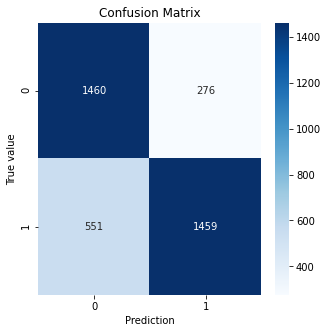

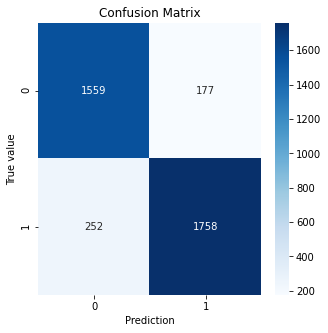

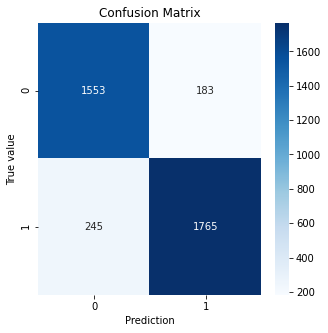

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
import re
import emoji
import string
import contractions
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import LancasterStemmer
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt')


df = pd.read_csv("tweet_data.csv")

stop_words = set(stopwords.words('english'))
porter_stemmer = PorterStemmer()
lancaster_stemmer = LancasterStemmer()
snoball_stemmer = SnowballStemmer('english')
lemmatizer = WordNetLemmatizer()

def replace_retweet(tweet, default_replace=""):
  tweet = re.sub('RT\s+', default_replace, tweet)
  return tweet

def replace_user(tweet, default_replace="twitteruser"):
  tweet = re.sub('\B@\w+', default_replace, tweet)
  return tweet

def demojise(tweet):
  tweet = emoji.demojize(tweet)
  return tweet

def replace_url(tweet, default_replace=""):
  tweet = re.sub('(http|https):\/\/\S+', default_replace, tweet)
  return tweet

def replace_hashtag(tweet, default_replace=""):
  tweet = re.sub('#+', default_replace, tweet)
  return tweet

def to_lowercase(tweet):
  tweet = tweet.lower()
  return tweet

def word_repetition(tweet):
  tweet = re.sub(r'(.)\1+', r'\1\1', tweet)
  return tweet

def punct_repetition(tweet, default_replace=""):
  tweet = re.sub(r'[\?\.\!]+(?=[\?\.\!])', default_replace, tweet)
  return tweet

def _fix_contractions(tweet):
  tweet = contractions.fix(tweet)
  return tweet

def tokenize(tweet):
  tokens = word_tokenize(tweet)
  return tokens

def custom_tokenize(tweet,
                    keep_punct = False,
                    keep_alnum = False,
                    keep_stop = False):
  
  token_list = word_tokenize(tweet)

  if not keep_punct:
    token_list = [token for token in token_list
                  if token not in string.punctuation]

  if not keep_alnum:
    token_list = [token for token in token_list if token.isalpha()]
  
  if not keep_stop:
    stop_words = set(stopwords.words('english'))
    stop_words.discard('not')
    token_list = [token for token in token_list if not token in stop_words]

  return token_list

def stem_tokens(tokens, stemmer):
  token_list = []
  for token in tokens:
    token_list.append(stemmer.stem(token))
  return token_list

def lemmatize_tokens(tokens, word_type, lemmatizer):
  token_list = []
  for token in tokens:
    token_list.append(lemmatizer.lemmatize(token, word_type[token]))
  return token_list

def process_tweet(tweet, verbose=False):
  if verbose: print("Initial tweet: {}".format(tweet))

  ## Twitter Features
  tweet = replace_retweet(tweet) # replace retweet
  tweet = replace_user(tweet, "") # replace user tag
  tweet = replace_url(tweet) # replace url
  tweet = replace_hashtag(tweet) # replace hashtag
  if verbose: print("Post Twitter processing tweet: {}".format(tweet))

  ## Word Features
  tweet = to_lowercase(tweet) # lower case
  tweet = _fix_contractions(tweet) # replace contractions
  tweet = punct_repetition(tweet) # replace punctuation repetition
  tweet = word_repetition(tweet) # replace word repetition
  tweet = demojise(tweet) # replace emojis
  if verbose: print("Post Word processing tweet: {}".format(tweet))

  ## Tokenization & Stemming
  tokens = custom_tokenize(tweet, keep_alnum=False, keep_stop=False) # tokenize
  stemmer = SnowballStemmer("english") # define stemmer
  stem = stem_tokens(tokens, stemmer) # stem tokens

  return stem

#Adding 2 new columns tokens & tweet_sentiment
#Apply process_tweet function created in above section to the entire DataFrame
df["tokens"] = df["tweet_text"].apply(process_tweet)
#Convert sentiment to 1 for "positive" and 0 for "negative" sentiment
df["tweet_sentiment"] = df["sentiment"].apply(lambda i: 1
                                              if i == "positive" else 0)

#Convert DataFrame to two lists: one for the tweet tokens (X) and one for the tweet sentiment (y)
X = df["tokens"].tolist()
y = df["tweet_sentiment"].tolist()

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    random_state=0,
                                                    train_size=0.80)

#Positive/Negative Frequency 
def build_freqs(tweet_list, sentiment_list):
  freqs = {}
  for tweet, sentiment in zip(tweet_list, sentiment_list):
    for word in tweet:
      pair = (word, sentiment)
      if pair in freqs:
        freqs[pair] += 1
      else:
        freqs[pair] = 1
  return freqs

def tweet_to_freq(tweet, freqs):
  x = np.zeros((2,))
  for word in tweet:
    if (word, 1) in freqs:
      x[0] += freqs[(word, 1)]
    if (word, 0) in freqs:
      x[1] += freqs[(word, 0)]
  return x

#Count Vectoriser/ Bag of Words
def fit_cv(tweet_corpus):
  cv_vect = CountVectorizer(tokenizer=lambda x: x,
                            preprocessor=lambda x: x)
  cv_vect.fit(tweet_corpus)
  return cv_vect

#TF-IDF
def fit_tfidf(tweet_corpus):
  tf_vect = TfidfVectorizer(preprocessor=lambda x: x,
                            tokenizer=lambda x: x)
  tf_vect.fit(tweet_corpus)
  return tf_vect

def fit_lr(X_train, y_train):
  model = LogisticRegression()
  model.fit(X_train, y_train)
  return model

#model based on pos/neg freq
freqs = build_freqs(X_train, y_train)
X_train_pn = [tweet_to_freq(tweet, freqs) for tweet in X_train]
X_test_pn = [tweet_to_freq(tweet, freqs) for tweet in X_test]

model_lr_pn = fit_lr(X_train_pn, y_train)

#model based on count vector
cv = fit_cv(X_train)
X_train_cv = cv.transform(X_train)
X_test_cv = cv.transform(X_test)

model_lr_cv = fit_lr(X_train_cv, y_train)
print(model_lr_pn.coef_, model_lr_pn.intercept_)

#model based on tf-idf
tf = fit_tfidf(X_train)
X_train_tf = tf.transform(X_train)
X_test_tf = tf.transform(X_test)

model_lr_tf = fit_lr(X_train_tf, y_train)

def plot_confusion(cm):
  plt.figure(figsize = (5,5))
  sn.heatmap(cm, annot=True, cmap="Blues", fmt='.0f')
  plt.xlabel("Prediction")
  plt.ylabel("True value")
  plt.title("Confusion Matrix")
  return sn

#pos/neg
y_pred_lr_pn = model_lr_pn.predict(X_test_pn)
print("LR Model Accuracy: {:.2%}".format(accuracy_score(y_test, y_pred_lr_pn)))
plot_confusion(confusion_matrix(y_test, y_pred_lr_pn))

#count vector
y_pred_lr_cv = model_lr_cv.predict(X_test_cv)
print("LR Model Accuracy: {:.2%}".format(accuracy_score(y_test, y_pred_lr_cv)))
plot_confusion(confusion_matrix(y_test, y_pred_lr_cv))

#tf-idf
y_pred_lr_tf = model_lr_tf.predict(X_test_tf)
print("LR Model Accuracy: {:.2%}".format(accuracy_score(y_test, y_pred_lr_tf)))
plot_confusion(confusion_matrix(y_test, y_pred_lr_tf))

In [ ]:
your_tweet = """enter your tweet here to predict sentiment"""

def predict_tweet(tweet):
  processed_tweet = process_tweet(tweet)
  transformed_tweet = tf.transform([processed_tweet])
  prediction = model_lr_tf.predict(transformed_tweet)

  if prediction == 1:
    return "Positive sentiment predicted!"
  else:
    return "Negative sentiment predicted."
  
predict_tweet(your_tweet)